<a href="https://colab.research.google.com/github/NSJayaweera/NCD-Risk_Prediction/blob/Chronic_Kidney_Diseases/Chronic_Kidney_Disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Chronic Kidney Disease (CKD) Prediction**

In [193]:
# Drive mounting (Colab)

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Import libraries & Setup**

In [194]:
# General
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn utilities
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    roc_curve,
    auc,
    log_loss
)

# Classical ML models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier
)

# Gradient boosting (XGBoost)
from xgboost import XGBClassifier

# Neural Network (Keras / TensorFlow)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

# Other
import math

# Global Configuration

RANDOM_STATE = 42              # for reproducibility
TEST_SIZE = 0.30               # 30% test split
VAL_SIZE = 0.30                # 30% of train used as validation
TARGET_COL = "CKD_Status"

DATA_PATH = "/content/drive/MyDrive/DSGP Kidney disease/kidney_disease_dataset.csv"

# Plotting style (optional, for cleaner graphs)
plt.style.use("seaborn-v0_8")
sns.set_palette("Set2")

Load dataset

In [195]:
# Load dataset
ckd_df = pd.read_csv(DATA_PATH)

# Make a copy
df = ckd_df.copy()
print(f"Shape of dataset: {df.shape}\n")

# Remove leakage feature
df = df.drop(columns=["Dialysis_Needed"])

# Display first 5 rows
print("First 5 Rows:")
display(df.head())

Shape of dataset: (2304, 9)

First 5 Rows:


,Age,Creatinine_Level,BUN,Diabetes,Hypertension,GFR,Urine_Output,CKD_Status
0,71,0.30,40.9,0,1,46.8,1622.0,1
1,34,1.79,17.1,0,0,43.8,1428.0,1
2,80,2.67,15.0,0,1,78.2,1015.0,1
3,40,0.97,31.1,0,1,92.8,1276.0,1
4,43,2.05,22.8,1,1,62.2,1154.0,0


# **Exploratory Data Analysis**

In [196]:
# Select numeric columns
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

print("Numeric columns:")
print(numerical_cols)

Numeric columns:
['Age', 'Creatinine_Level', 'BUN', 'Diabetes', 'Hypertension', 'GFR', 'Urine_Output', 'CKD_Status']


Basic dataset information

In [197]:
# Basic dataset Information: datatypes + non-null counts
print("\nDataset Information:")
df.info()

# Summary statistics (numeric only)
print("\nSummary Statistics:")
display(df.describe())


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2304 entries, 0 to 2303
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               2304 non-null   int64  
 1   Creatinine_Level  2304 non-null   float64
 2   BUN               2304 non-null   float64
 3   Diabetes          2304 non-null   int64  
 4   Hypertension      2304 non-null   int64  
 5   GFR               2304 non-null   float64
 6   Urine_Output      2304 non-null   float64
 7   CKD_Status        2304 non-null   int64  
dtypes: float64(4), int64(4)
memory usage: 144.1 KB

Summary Statistics:


,Age,Creatinine_Level,BUN,Diabetes,Hypertension,GFR,Urine_Output,CKD_Status
count,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000
mean,54.159288,1.305638,18.813672,0.406684,0.498264,68.953863,1309.189670,0.508681
std,20.513729,0.789594,10.508358,0.491322,0.500106,24.660191,491.951914,0.500033
min,20.000000,0.300000,5.000000,0.000000,0.000000,5.000000,100.000000,0.000000
25%,36.000000,0.620000,9.975000,0.000000,0.000000,51.300000,967.750000,0.000000
50%,54.000000,1.240000,18.200000,0.000000,0.000000,69.150000,1295.500000,1.000000
75%,72.000000,1.842500,26.000000,1.000000,1.000000,86.300000,1633.500000,1.000000
max,90.000000,4.130000,61.900000,1.000000,1.000000,120.000000,2899.000000,1.000000


Target distribution

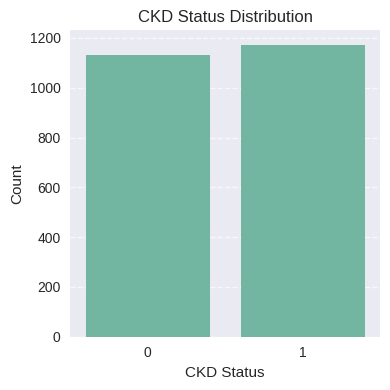

Class Counts:
CKD_Status
1    1172
0    1132
Name: count, dtype: int64

Class Proportions:
CKD_Status
1    0.508681
0    0.491319
Name: proportion, dtype: float64


In [198]:
# Target Variable Distribution

plt.figure(figsize=(4, 4))
sns.countplot(x=TARGET_COL, data=df)
plt.title("CKD Status Distribution")
plt.xlabel("CKD Status")
plt.ylabel("Count")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

print("Class Counts:")
print(df[TARGET_COL].value_counts())
print("\nClass Proportions:")
print(df[TARGET_COL].value_counts(normalize=True))

In [199]:
# Checking for missing values
print("\nMissing Values per Column:")
display(df.isnull().sum())


Missing Values per Column:


,0
Age,0
Creatinine_Level,0
BUN,0
Diabetes,0
Hypertension,0
GFR,0
Urine_Output,0
CKD_Status,0


In [200]:
# Check for duplicate rows
print("\nDuplicate Rows:")
print(df.duplicated().sum())


Duplicate Rows:
0


In [201]:
# IQR Outlier Detection
outlier_mask = pd.Series(False, index=df.index)

print("Outlier counts per numeric column (IQR method):")

for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    col_outliers = (df[col] < lower_bound) | (df[col] > upper_bound)
    outlier_mask |= col_outliers

    print(f"{col}: {col_outliers.sum()}")


Outlier counts per numeric column (IQR method):
Age: 0
Creatinine_Level: 8
BUN: 9
Diabetes: 0
Hypertension: 0
GFR: 0
Urine_Output: 9
CKD_Status: 0


In [202]:
# Detection of medically impossible values

invalid_age = ~df["Age"].between(0, 110)
invalid_creat = ~df["Creatinine_Level"].between(0.1, 20)
invalid_bun = ~df["BUN"].between(1, 150)
invalid_gfr = ~df["GFR"].between(0, 130)
invalid_urine = ~df["Urine_Output"].between(0, 10000)

print("\nInvalid counts per rule:")
print("Age:", invalid_age.sum())
print("Creatinine_Level:", invalid_creat.sum())
print("BUN:", invalid_bun.sum())
print("GFR:", invalid_gfr.sum())
print("Urine_Output:", invalid_urine.sum())



Invalid counts per rule:
Age: 0
Creatinine_Level: 0
BUN: 0
GFR: 0
Urine_Output: 0


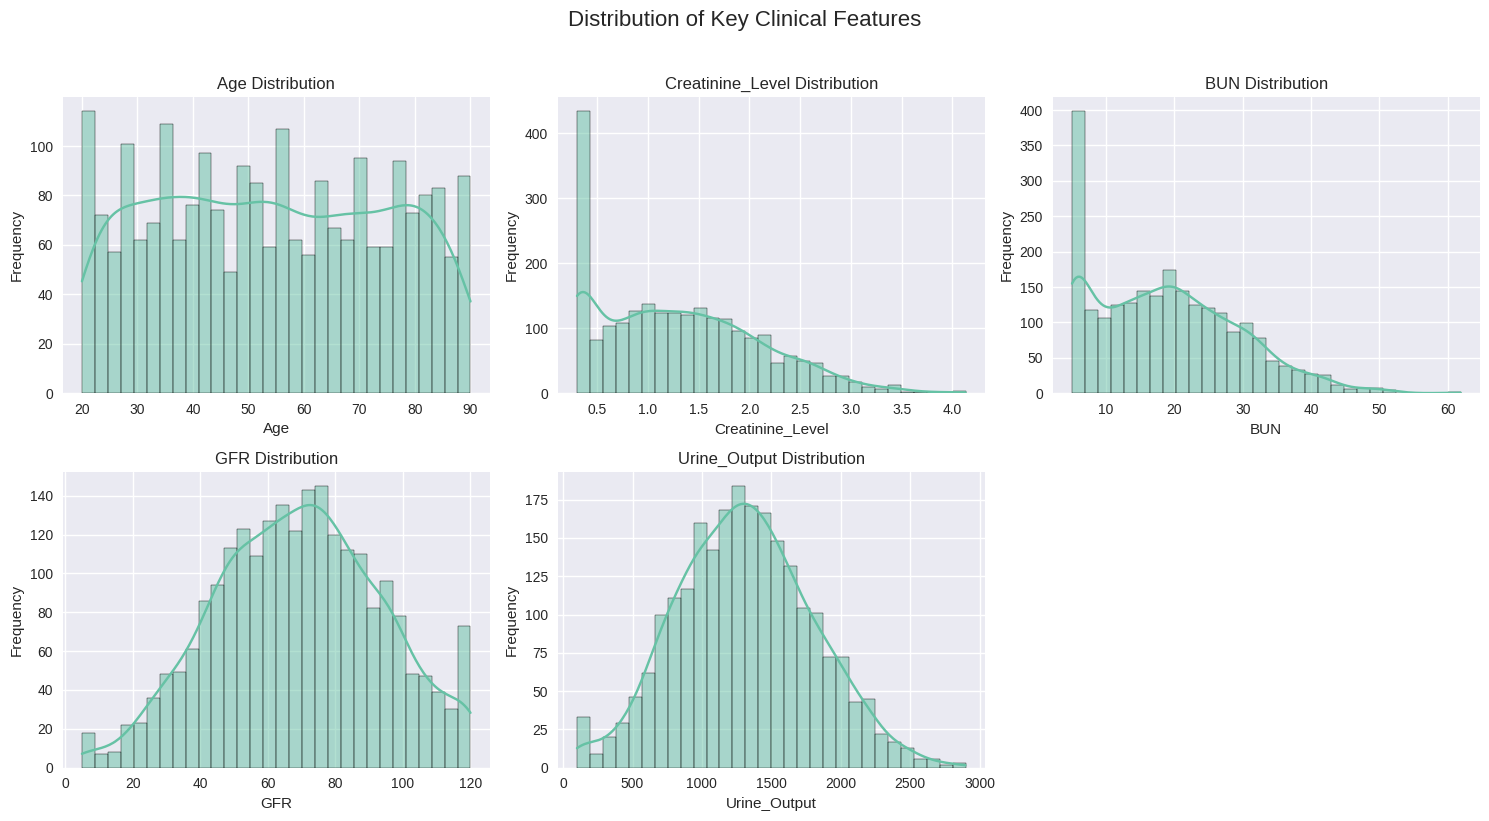

In [203]:
# Histogram

# Select key features only
hist_cols = [
    "Age",
    "Creatinine_Level",
    "BUN",
    "GFR",
    "Urine_Output"
]

n_cols = 3
n_rows = math.ceil(len(hist_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(hist_cols):
    sns.histplot(
        df[col],
        bins=30,
        kde=True,
        ax=axes[i]
    )
    axes[i].set_title(f"{col} Distribution")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Distribution of Key Clinical Features", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


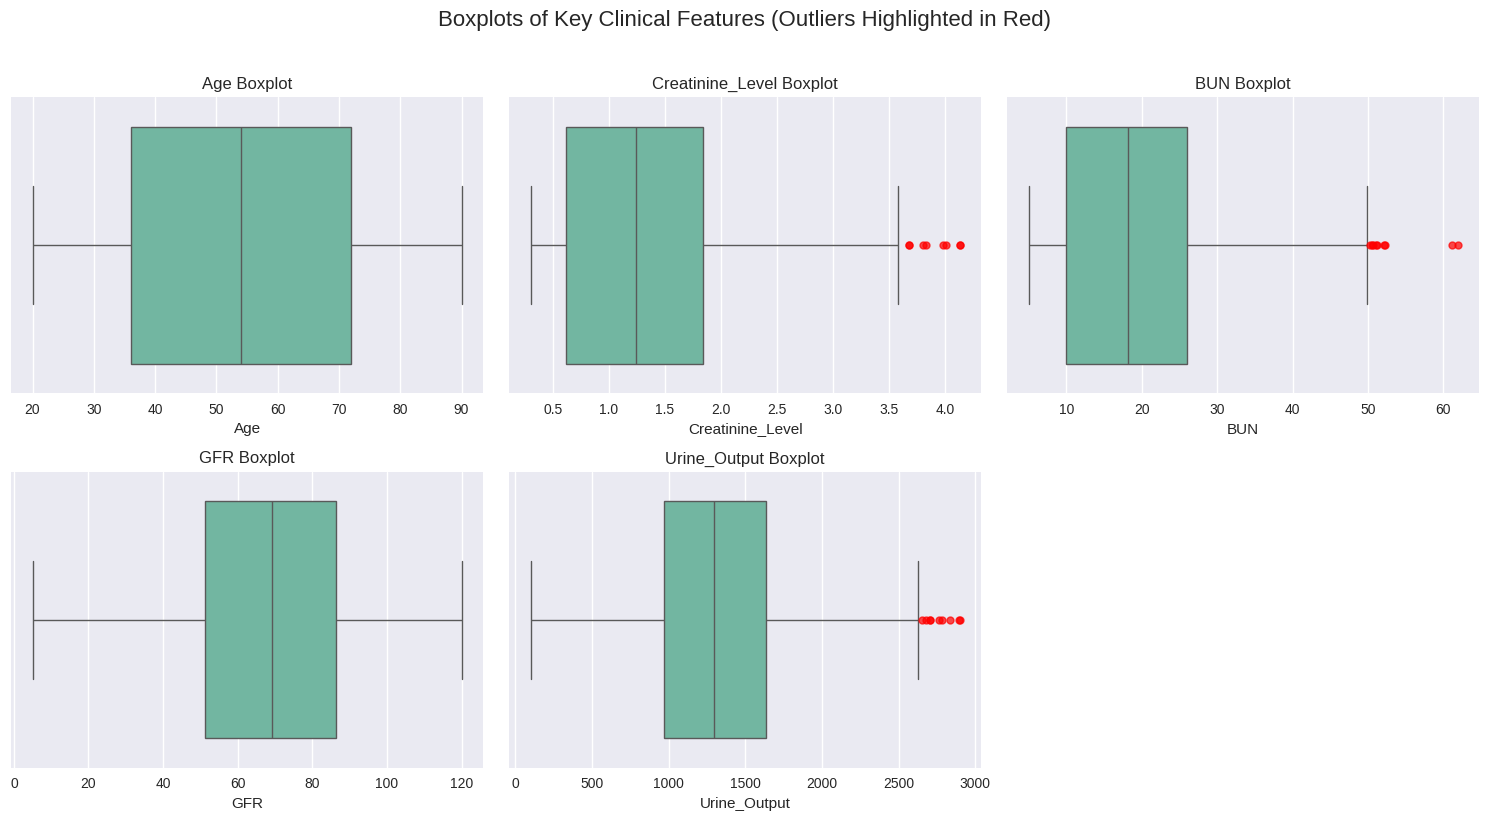

In [204]:
# Boxplot Grid with Red Outliers

box_cols = [
    "Age",
    "Creatinine_Level",
    "BUN",
    "GFR",
    "Urine_Output"
]

n_cols = 3
n_rows = math.ceil(len(box_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

# Style for outliers
flierprops = dict(
    marker='o',
    markerfacecolor='red',
    markeredgecolor='red',
    markersize=5,
    alpha=0.7
)

for i, col in enumerate(box_cols):
    sns.boxplot(
        x=df[col],
        ax=axes[i],
        flierprops=flierprops
    )
    axes[i].set_title(f"{col} Boxplot")
    axes[i].set_xlabel(col)

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Boxplots of Key Clinical Features (Outliers Highlighted in Red)",
             fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


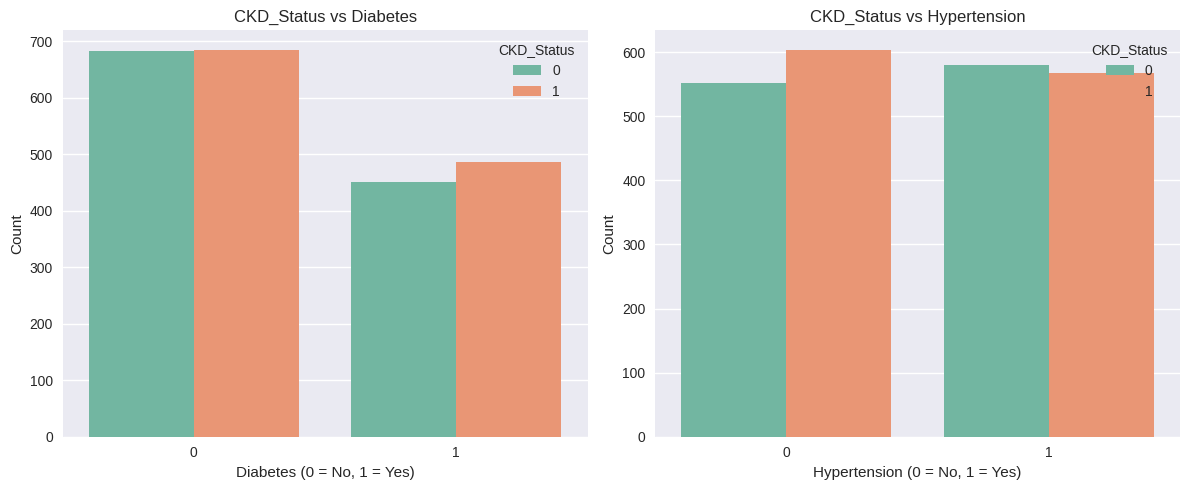

In [205]:
# CKD_Status vs Binary Clinical Conditions

binary_cols = [
    "Diabetes",
    "Hypertension"
]

cols = 2  # plots per row

for start in range(0, len(binary_cols), cols):
    end = start + cols
    subset = binary_cols[start:end]

    fig, axes = plt.subplots(1, cols, figsize=(12, 5))
    axes = axes.flatten()

    for i, col in enumerate(subset):
        sns.countplot(
            x=col,
            hue=TARGET_COL,
            data=df,
            ax=axes[i]
        )
        axes[i].set_title(f"{TARGET_COL} vs {col}")
        axes[i].set_xlabel(f"{col} (0 = No, 1 = Yes)")
        axes[i].set_ylabel("Count")
        axes[i].legend(title=TARGET_COL)

    # Remove empty axes
    for j in range(len(subset), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


##  Data Cleaning & Preprocessing

In [206]:
#Handle missing values

# Target
TARGET_COL = "CKD_Status"

# Binary columns
binary_cols = [
    "Diabetes",
    "Hypertension"
]

# Continuous columns (exclude target & binary)
continuous_cols = [
    col for col in df.columns
    if col not in binary_cols + [TARGET_COL]
]


# Remove rows with missing target
before_rows = df.shape[0]
df = df.dropna(subset=[TARGET_COL])
after_rows = df.shape[0]

print(f"Rows removed due to missing target: {before_rows - after_rows}")

for col in continuous_cols:
    median_value = df[col].median()
    df[col].fillna(median_value, inplace=True)

for col in binary_cols:
    mode_value = df[col].mode()[0]
    df[col].fillna(mode_value, inplace=True)

print("\nMissing values after handling:")
display(df.isnull().sum())


Rows removed due to missing target: 0

Missing values after handling:


,0
Age,0
Creatinine_Level,0
BUN,0
Diabetes,0
Hypertension,0
GFR,0
Urine_Output,0
CKD_Status,0


In [207]:
# Remove duplicate rows

before_rows = df.shape[0]
df = df.drop_duplicates()
after_rows = df.shape[0]

print("\nDuplicate rows removed:", before_rows - after_rows)
print("Shape after removing duplicates:", df.shape)

# Verify no duplicates remain
print("\nDuplicate rows after removal:")
print(df.duplicated().sum())


Duplicate rows removed: 0
Shape after removing duplicates: (2304, 8)

Duplicate rows after removal:
0


In [208]:
# Remove Medically Impossible Values

# Define medically valid ranges
valid_filter = (
    (df["Age"].between(0, 110)) &
    (df["Creatinine_Level"].between(0.1, 20)) &
    (df["BUN"].between(1, 150)) &
    (df["GFR"].between(0, 130)) &
    (df["Urine_Output"].between(0, 10000))
)

before_shape = df.shape

# Apply filter
df = df.loc[valid_filter]

after_shape = df.shape

print("Shape before medical anomaly removal:", before_shape)
print("Shape after medical anomaly removal: ", after_shape)
print("Rows removed:", before_shape[0] - after_shape[0])


Shape before medical anomaly removal: (2304, 8)
Shape after medical anomaly removal:  (2304, 8)
Rows removed: 0


In [209]:
# Feature Engineering: BUN / Creatinine Ratio

# Create ratio
df["BUN_Creat_Ratio"] = df["BUN"] / df["Creatinine_Level"].replace(0, np.nan)

# If any NaNs were created due to 0 creatinine fill them with the median ratio
df["BUN_Creat_Ratio"] = df["BUN_Creat_Ratio"].fillna(df["BUN_Creat_Ratio"].median())

print("New Feature Added: BUN_Creat_Ratio")
print("Dataset Shape After Feature Engineering:", df.shape)

# Verification
display(df[["BUN", "Creatinine_Level", "BUN_Creat_Ratio"]].head())


New Feature Added: BUN_Creat_Ratio
Dataset Shape After Feature Engineering: (2304, 9)


,BUN,Creatinine_Level,BUN_Creat_Ratio
0,40.9,0.30,136.333333
1,17.1,1.79,9.553073
2,15.0,2.67,5.617978
3,31.1,0.97,32.061856
4,22.8,2.05,11.121951


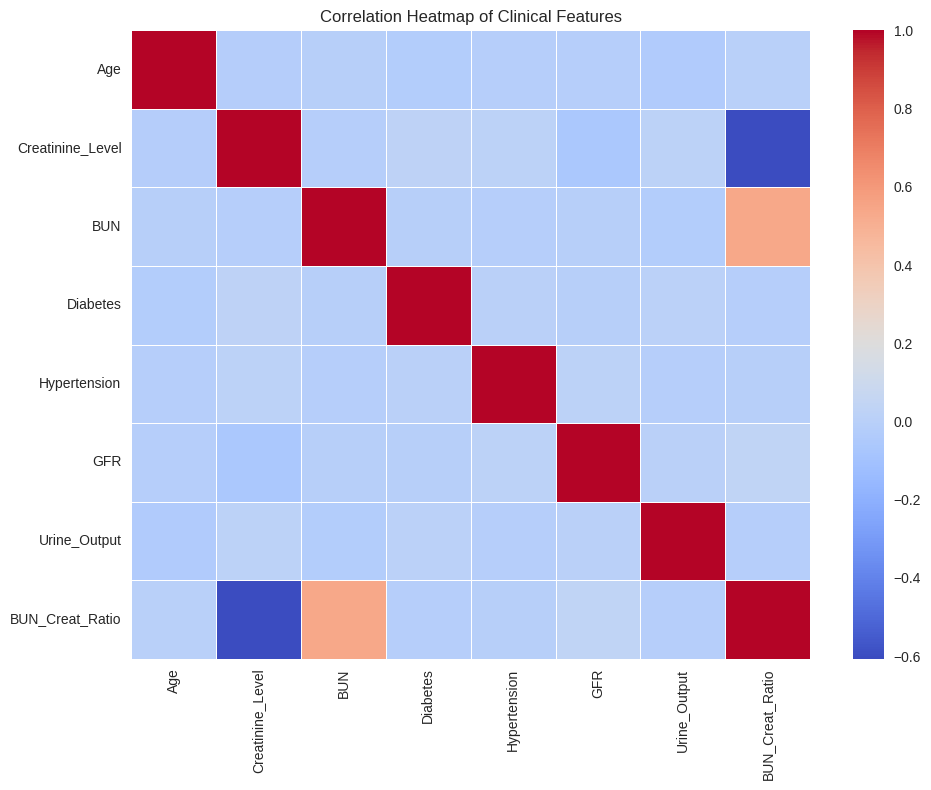

In [210]:
# Correlation Heatmap

# Select feature columns (exclude target)
feature_cols = df.drop(columns=[TARGET_COL])

# Compute correlation matrix
corr_matrix = feature_cols.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    annot=False,
    linewidths=0.5
)

plt.title("Correlation Heatmap of Clinical Features")
plt.tight_layout()
plt.show()

In [211]:
# Define Features (X) and Target (y)
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

print("Feature shape:", X.shape)
print("Target shape:", y.shape)

Feature shape: (2304, 8)
Target shape: (2304,)


In [212]:
# Train–Test Split

from sklearn.model_selection import train_test_split

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,          # e.g., 0.30
    random_state=RANDOM_STATE,
    stratify=y
)

print("Train_full shape:", X_train_full.shape)
print("Test shape:      ", X_test.shape)


# Train–Validation Split (from Training Data)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=VAL_SIZE,           # e.g., 0.30 of train_full
    random_state=RANDOM_STATE,
    stratify=y_train_full
)

print("Train shape:     ", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:      ", X_test.shape)

# Identify Binary & Continuous Columns

binary_cols = ["Diabetes", "Hypertension"]
continuous_cols = [col for col in X.columns if col not in binary_cols]

print("Binary columns:     ", binary_cols)
print("Continuous columns: ", continuous_cols)


# Scaling (Z-score) - Scale ONLY Continuous Features

scaler = StandardScaler()

# Fit scaler on TRAIN only
X_train_scaled = X_train.copy()
X_val_scaled   = X_val.copy()
X_test_scaled  = X_test.copy()

X_train_scaled[continuous_cols] = scaler.fit_transform(X_train[continuous_cols])
X_val_scaled[continuous_cols]   = scaler.transform(X_val[continuous_cols])
X_test_scaled[continuous_cols]  = scaler.transform(X_test[continuous_cols])

print("Scaling complete.")
print("X_train_scaled shape:", X_train_scaled.shape)
print("X_val_scaled shape:  ", X_val_scaled.shape)
print("X_test_scaled shape: ", X_test_scaled.shape)


Train_full shape: (1612, 8)
Test shape:       (692, 8)
Train shape:      (1128, 8)
Validation shape: (484, 8)
Test shape:       (692, 8)
Binary columns:      ['Diabetes', 'Hypertension']
Continuous columns:  ['Age', 'Creatinine_Level', 'BUN', 'GFR', 'Urine_Output', 'BUN_Creat_Ratio']
Scaling complete.
X_train_scaled shape: (1128, 8)
X_val_scaled shape:   (484, 8)
X_test_scaled shape:  (692, 8)


In [213]:
# Classical Models

classical_models = {
    "Logistic Regression": LogisticRegression(
        max_iter=2000,
        random_state=RANDOM_STATE
    ),

    "KNN": KNeighborsClassifier(
        n_neighbors=5
    ),

    "SVM (RBF)": SVC(
        kernel="rbf",
        C=1.0,
        gamma="scale",
        probability=True,
        random_state=RANDOM_STATE
    ),

    "Decision Tree": DecisionTreeClassifier(
        random_state=RANDOM_STATE
    )
}

results = []

for name, model in classical_models.items():
    # Train
    model.fit(X_train_scaled, y_train)

    # Predict
    y_pred = model.predict(X_test_scaled)

    # Probabilities for ROC–AUC
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_prob = model.decision_function(X_test_scaled)

    acc = accuracy_score(y_test, y_pred) * 100
    roc_auc = roc_auc_score(y_test, y_prob)

    results.append({
        "Model": name,
        "Accuracy (%)": round(acc, 2),
        "ROC–AUC": round(roc_auc, 3)
    })

# Create DataFrame
results_df = pd.DataFrame(results)

# Reset index
results_df = results_df.reset_index(drop=True)
display(results_df.style.hide(axis="index"))

Model,Accuracy (%),ROC–AUC
Logistic Regression,83.820000,0.922000
KNN,89.160000,0.952000
SVM (RBF),94.650000,0.993000
Decision Tree,100.000000,1.000000


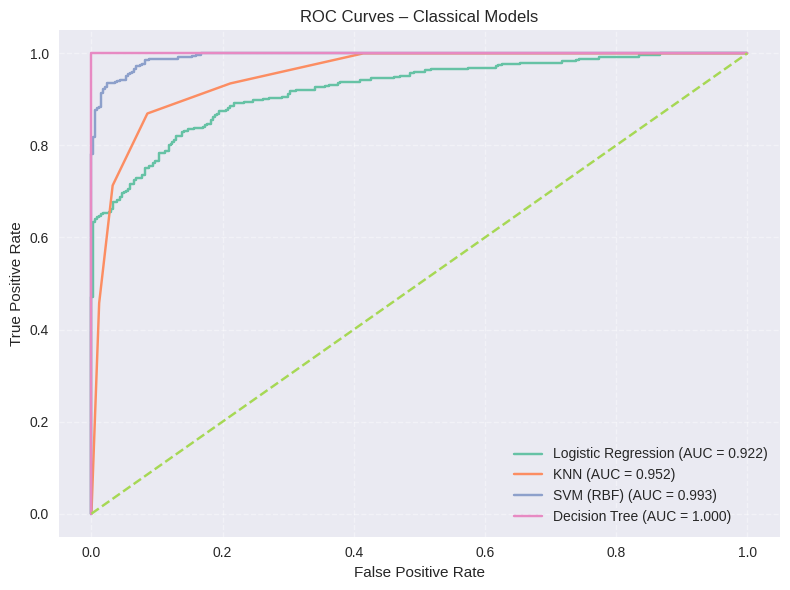

In [214]:
# Classical Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, random_state=RANDOM_STATE),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVM (RBF)": SVC(kernel="rbf", probability=True, random_state=RANDOM_STATE),
    "Decision Tree": DecisionTreeClassifier(random_state=RANDOM_STATE)
}

plt.figure(figsize=(8, 6))
auc_scores = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)

    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_score = model.decision_function(X_test_scaled)

    fpr, tpr, _ = roc_curve(y_test, y_score)
    model_auc = auc(fpr, tpr)
    auc_scores[name] = model_auc

    plt.plot(fpr, tpr, label=f"{name} (AUC = {model_auc:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("ROC Curves – Classical Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

In [215]:
# Classification Reports
for name, model in models.items():
    print("\n" + "=" * 60)
    print(f"Classification Report: {name}")
    print("=" * 60)

    # Train model
    model.fit(X_train, y_train)

    # Predictions on test set
    y_pred = model.predict(X_test)

    # Classification report
    print(
        classification_report(
            y_test,
            y_pred,
            target_names=["Non-CKD", "CKD"]
        )
    )


Classification Report: Logistic Regression
              precision    recall  f1-score   support

     Non-CKD       0.83      0.84      0.83       340
         CKD       0.84      0.84      0.84       352

    accuracy                           0.84       692
   macro avg       0.84      0.84      0.84       692
weighted avg       0.84      0.84      0.84       692


Classification Report: KNN
              precision    recall  f1-score   support

     Non-CKD       0.74      0.84      0.79       340
         CKD       0.82      0.72      0.77       352

    accuracy                           0.78       692
   macro avg       0.78      0.78      0.78       692
weighted avg       0.78      0.78      0.78       692


Classification Report: SVM (RBF)
              precision    recall  f1-score   support

     Non-CKD       0.72      0.50      0.59       340
         CKD       0.63      0.81      0.71       352

    accuracy                           0.66       692
   macro avg       0.6

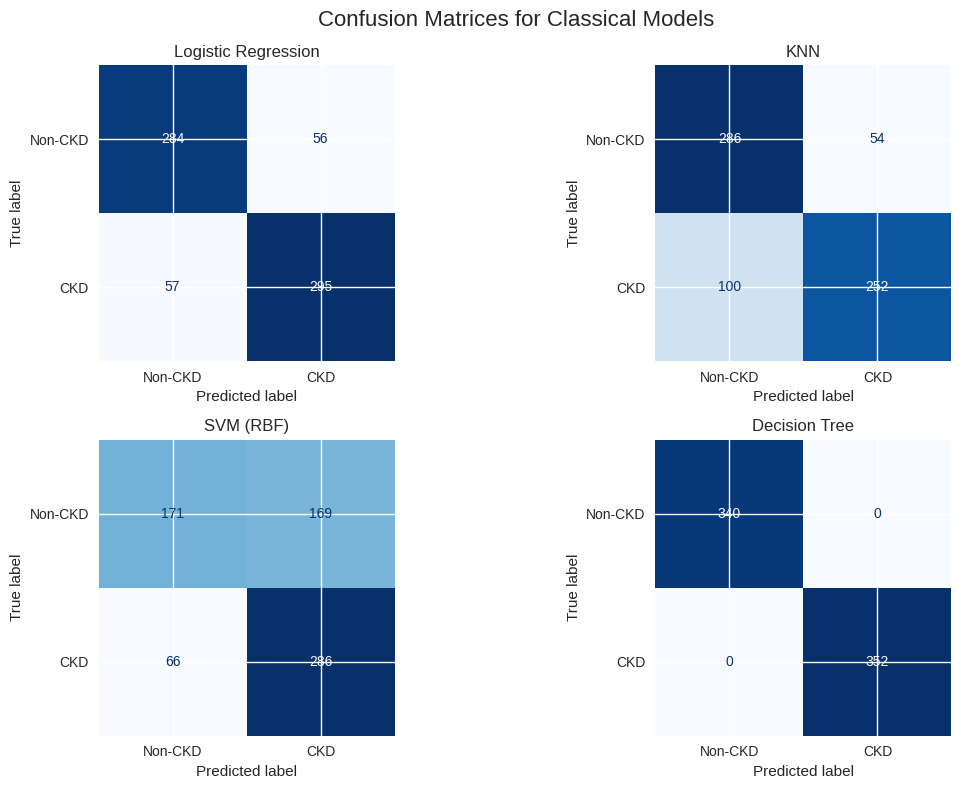

In [216]:
# confusion matrices
n_cols = 2
n_rows = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 8))
axes = axes.flatten()

for i, (name, model) in enumerate(models.items()):
    # Train model
    model.fit(X_train, y_train)

    # Predict on test set
    y_pred = model.predict(X_test)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=["Non-CKD", "CKD"]
    )

    disp.plot(ax=axes[i], cmap="Blues", colorbar=False)
    axes[i].set_title(name)

# Remove unused subplot
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Confusion Matrices for Classical Models", fontsize=16)
plt.tight_layout()
plt.show()

In [217]:
ensemble_models = {
    # Bagging
    "Bagging (Decision Trees)": BaggingClassifier(
        estimator=DecisionTreeClassifier(random_state=RANDOM_STATE),
        n_estimators=200,
        random_state=RANDOM_STATE
    ),

    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        max_features="sqrt",
        random_state=RANDOM_STATE
    ),

   # Boosting

    "AdaBoost": AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1, random_state=RANDOM_STATE),
        n_estimators=200,
        learning_rate=0.1,
        random_state=RANDOM_STATE
    ),

    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.1,
        random_state=RANDOM_STATE
    ),

    "XGBoost": XGBClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=3,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_STATE,
        eval_metric="logloss",
        use_label_encoder=False
    )
}

In [218]:
ensemble_results = []

for name, model in ensemble_models.items():
    # Train on TRAIN set
    model.fit(X_train_scaled, y_train)

    # Predictions on TEST set
    y_pred = model.predict(X_test_scaled)

    # Accuracy (%)
    acc = accuracy_score(y_test, y_pred) * 100

    # ROC–AUC (use probabilities if available)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_prob = model.decision_function(X_test_scaled)

    roc_auc = roc_auc_score(y_test, y_prob)

    ensemble_results.append({
        "Model": name,
        "Accuracy (%)": round(acc, 2),
        "ROC–AUC": round(roc_auc, 4)
    })

ensemble_results_df = pd.DataFrame(ensemble_results)
display(ensemble_results_df.style.hide(axis="index"))

Model,Accuracy (%),ROC–AUC
Bagging (Decision Trees),100.000000,1.000000
Random Forest,99.710000,1.000000
AdaBoost,96.970000,1.000000
Gradient Boosting,100.000000,1.000000
XGBoost,99.570000,1.000000


In [219]:
print("\n" + "="*70)
print("CLASSIFICATION REPORTS — ENSEMBLE MODELS")
print("="*70)

for name, model in ensemble_models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    print("\n" + "-"*60)
    print(f"{name}")
    print("-"*60)
    print(classification_report(
        y_test, y_pred,
        target_names=["Non-CKD", "CKD"]
    ))


CLASSIFICATION REPORTS — ENSEMBLE MODELS

------------------------------------------------------------
Bagging (Decision Trees)
------------------------------------------------------------
              precision    recall  f1-score   support

     Non-CKD       1.00      1.00      1.00       340
         CKD       1.00      1.00      1.00       352

    accuracy                           1.00       692
   macro avg       1.00      1.00      1.00       692
weighted avg       1.00      1.00      1.00       692


------------------------------------------------------------
Random Forest
------------------------------------------------------------
              precision    recall  f1-score   support

     Non-CKD       1.00      0.99      1.00       340
         CKD       0.99      1.00      1.00       352

    accuracy                           1.00       692
   macro avg       1.00      1.00      1.00       692
weighted avg       1.00      1.00      1.00       692


------------------

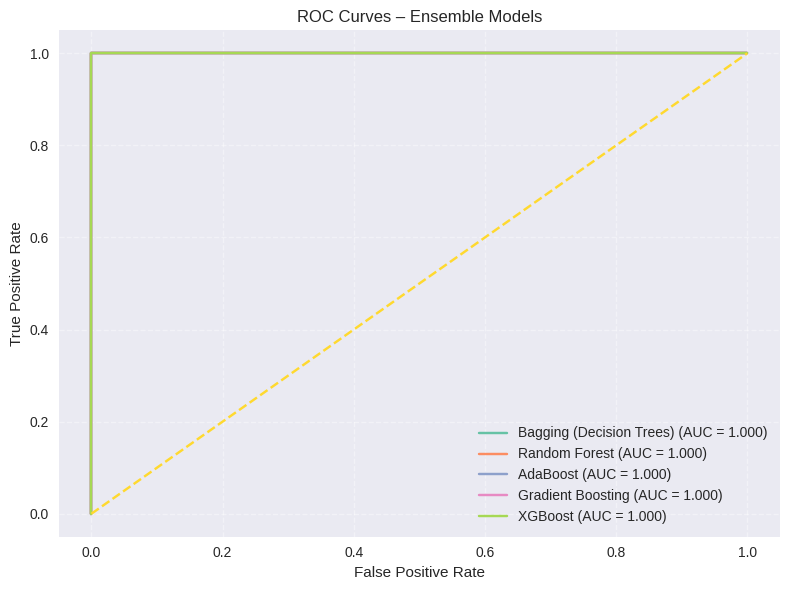

In [220]:
plt.figure(figsize=(8, 6))
auc_scores = {}

for name, model in ensemble_models.items():
    model.fit(X_train_scaled, y_train)

    y_score = model.predict_proba(X_test_scaled)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_score)
    model_auc = auc(fpr, tpr)
    auc_scores[name] = model_auc

    plt.plot(fpr, tpr, label=f"{name} (AUC = {model_auc:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("ROC Curves – Ensemble Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

In [221]:
# Stacking

# Base learners (choose a small, diverse set)
base_learners = [
    ("lr", LogisticRegression(max_iter=2000, random_state=RANDOM_STATE)),
    ("svm", SVC(kernel="rbf", probability=True, random_state=RANDOM_STATE)),
    ("knn", KNeighborsClassifier(n_neighbors=5)),
    ("dt", DecisionTreeClassifier(random_state=RANDOM_STATE))
]

# Meta-learner
meta_learner = LogisticRegression(max_iter=2000, random_state=RANDOM_STATE)

# Stacking model
stack_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=5,                  # internal CV for stacking
    passthrough=False      # set True if you want original features also passed to meta-model
)

# Train
stack_model.fit(X_train_scaled, y_train)

# Predict (Test)
y_pred_stack = stack_model.predict(X_test_scaled)

# Accuracy (%)
stack_acc = accuracy_score(y_test, y_pred_stack) * 100

# ROC–AUC (use predict_proba if available)
y_prob_stack = stack_model.predict_proba(X_test_scaled)[:, 1]
stack_auc = roc_auc_score(y_test, y_prob_stack)

# Results table
stacking_df = pd.DataFrame([{
    "Model": "Stacking",
    "Accuracy (%)": round(stack_acc, 2),
    "ROC–AUC": round(stack_auc, 4)
}])

display(stacking_df.style.hide(axis="index"))

print("\n" + "="*70)
print("CLASSIFICATION REPORT — STACKING")
print("="*70)

print(classification_report(
    y_test, y_pred_stack,
    target_names=["Non-CKD", "CKD"]
))

Model,Accuracy (%),ROC–AUC
Stacking,100.000000,1.000000



CLASSIFICATION REPORT — STACKING
              precision    recall  f1-score   support

     Non-CKD       1.00      1.00      1.00       340
         CKD       1.00      1.00      1.00       352

    accuracy                           1.00       692
   macro avg       1.00      1.00      1.00       692
weighted avg       1.00      1.00      1.00       692



In [222]:
# ANN Model

Xtr = np.array(X_train_scaled)
Xva = np.array(X_val_scaled)
Xte = np.array(X_test_scaled)

ytr = np.array(y_train).reshape(-1,)
yva = np.array(y_val).reshape(-1,)
yte = np.array(y_test).reshape(-1,)


# Build ANN

ann = Sequential([
    Input(shape=(Xtr.shape[1],)),
    Dense(32, activation="relu"),
    Dropout(0.2),
    Dense(16, activation="relu"),
    Dropout(0.2),
    Dense(1, activation="sigmoid")   # binary output
])

ann.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Early Stopping (prevents overfitting)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

# Train
history = ann.fit(
    Xtr, ytr,
    validation_data=(Xva, yva),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

print("ANN trained successfully.")

# Evaluate on TEST (Accuracy + ROC–AUC)

# Predict probabilities
y_test_prob = ann.predict(Xte, verbose=0).ravel()

# Convert probabilities to class labels
y_test_pred = (y_test_prob >= 0.5).astype(int)

# Metrics
test_acc = accuracy_score(yte, y_test_pred) * 100
test_auc = roc_auc_score(yte, y_test_prob)

# Results table
ann_results_df = pd.DataFrame([{
    "Model": "ANN",
    "Accuracy (%)": round(test_acc, 2),
    "ROC–AUC": round(test_auc, 4)
}])

display(ann_results_df.style.hide(axis="index"))

# Classification Report
from sklearn.metrics import classification_report

print("\n" + "="*70)
print("CLASSIFICATION REPORT — ANN")
print("="*70)

print(classification_report(
    yte,
    y_test_pred,
    target_names=["Non-CKD", "CKD"]
))

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5235 - loss: 0.7259 - val_accuracy: 0.7087 - val_loss: 0.6398
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6753 - loss: 0.6167 - val_accuracy: 0.8058 - val_loss: 0.5614
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7408 - loss: 0.5660 - val_accuracy: 0.8512 - val_loss: 0.4793
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7819 - loss: 0.5044 - val_accuracy: 0.8657 - val_loss: 0.4099
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8160 - loss: 0.4490 - val_accuracy: 0.8657 - val_loss: 0.3560
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8344 - loss: 0.3973 - val_accuracy: 0.8740 - val_loss: 0.3222
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8347 - loss: 0.3793 - val_accuracy: 0.8760 - val_loss: 0.2979
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8267 - loss: 0.3666 - val_accuracy: 0.8843 - val_loss:

Model,Accuracy (%),ROC–AUC
ANN,96.240000,0.993900



CLASSIFICATION REPORT — ANN
              precision    recall  f1-score   support

     Non-CKD       0.96      0.96      0.96       340
         CKD       0.96      0.96      0.96       352

    accuracy                           0.96       692
   macro avg       0.96      0.96      0.96       692
weighted avg       0.96      0.96      0.96       692



22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


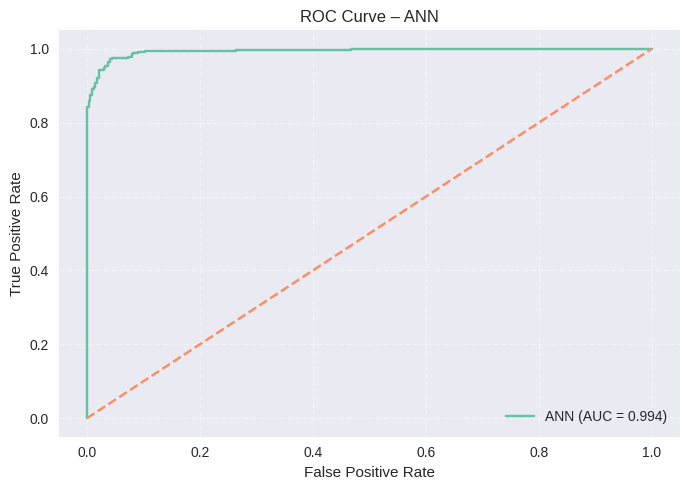

In [223]:
y_prob_ann = ann.predict(X_test_scaled).ravel()

fpr, tpr, _ = roc_curve(y_test, y_prob_ann)
ann_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"ANN (AUC = {ann_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("ROC Curve – ANN")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

In [224]:
xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    eval_metric="logloss",
    use_label_encoder=False
)

eval_set = [(X_train_scaled, y_train), (X_val_scaled, y_val)]
xgb.fit(X_train_scaled, y_train, eval_set=eval_set, verbose=False)

xgb_evals_result = xgb.evals_result()
print("xgb_evals_result created ")

xgb_evals_result created 


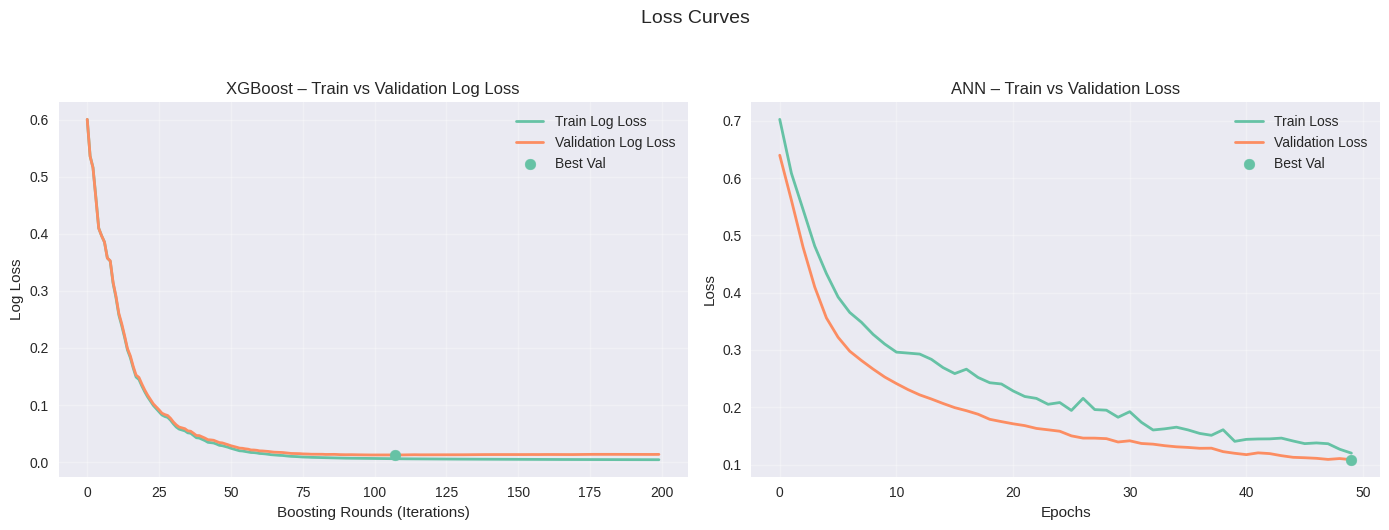

In [225]:
# XGBoost losses
train_loss_xgb = xgb_evals_result["validation_0"]["logloss"]
val_loss_xgb   = xgb_evals_result["validation_1"]["logloss"]
best_xgb_idx   = int(np.argmin(val_loss_xgb))

# ANN losses
train_loss_nn = history.history.get("loss", [])
val_loss_nn   = history.history.get("val_loss", [])
best_nn_idx   = int(np.argmin(val_loss_nn)) if len(val_loss_nn) > 0 else None

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# XGBoost
axes[0].plot(train_loss_xgb, label="Train Log Loss", linewidth=2)
axes[0].plot(val_loss_xgb, label="Validation Log Loss", linewidth=2)
axes[0].scatter(best_xgb_idx, val_loss_xgb[best_xgb_idx], s=60, zorder=5, label="Best Val")
axes[0].set_title("XGBoost – Train vs Validation Log Loss")
axes[0].set_xlabel("Boosting Rounds (Iterations)")
axes[0].set_ylabel("Log Loss")
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# ANN
axes[1].plot(train_loss_nn, label="Train Loss", linewidth=2)
axes[1].plot(val_loss_nn, label="Validation Loss", linewidth=2)
if best_nn_idx is not None:
    axes[1].scatter(best_nn_idx, val_loss_nn[best_nn_idx], s=60, zorder=5, label="Best Val")
axes[1].set_title("ANN – Train vs Validation Loss")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.suptitle("Loss Curves", fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


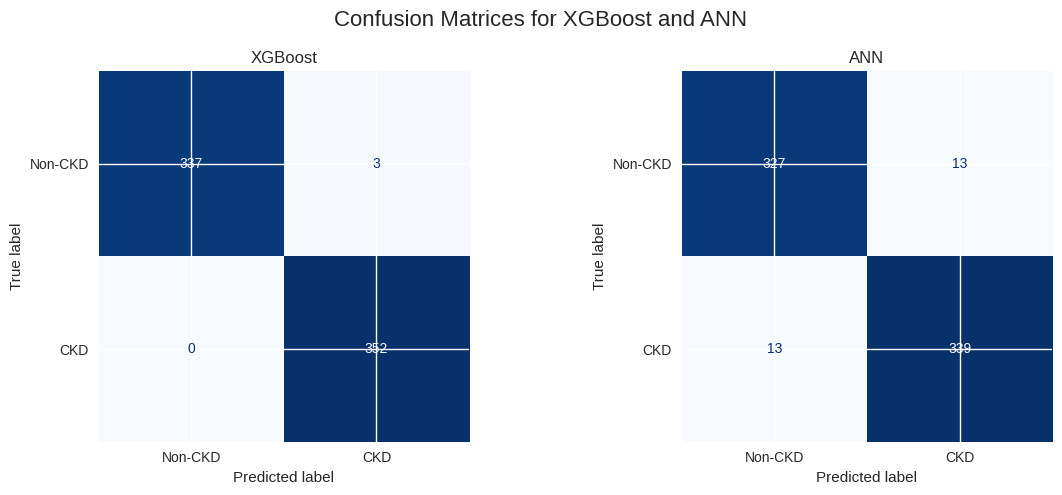

In [226]:
# Plot confusion matrices
n_cols = 2
n_rows = 1

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5))
axes = axes.flatten()

models = {
    "XGBoost": xgb,
    "ANN": ann
}

for i, (name, model) in enumerate(models.items()):

    if name == "XGBoost":
        # Predict using XGBoost
        y_pred = model.predict(X_test_scaled)

    else:
        # Predict using ANN
        y_prob = model.predict(Xte).ravel()
        y_pred = (y_prob >= 0.5).astype(int)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=["Non-CKD", "CKD"]
    )

    disp.plot(ax=axes[i], cmap="Blues", colorbar=False)
    axes[i].set_title(name)

plt.suptitle("Confusion Matrices for XGBoost and ANN", fontsize=16)
plt.tight_layout()
plt.show()


In [227]:
# MODEL COMPARISON

all_results = []

def evaluate_model(model, model_name):
    # Train
    model.fit(X_train_scaled, y_train)

    # Predict labels
    y_pred = model.predict(X_test_scaled)

    # Accuracy (%)
    acc = accuracy_score(y_test, y_pred) * 100

    # ROC–AUC
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_prob = model.decision_function(X_test_scaled)

    auc = roc_auc_score(y_test, y_prob)

    all_results.append({
        "Model": model_name,
        "Accuracy (%)": round(acc, 2),
        "ROC–AUC": round(auc, 4)
    })


# Classical Models

for name, model in classical_models.items():
    evaluate_model(model, name)


# Ensemble Models (Bagging & Boosting)

for name, model in ensemble_models.items():
    evaluate_model(model, name)


#  Stacking

stack_model.fit(X_train_scaled, y_train)
y_pred_stack = stack_model.predict(X_test_scaled)
y_prob_stack = stack_model.predict_proba(X_test_scaled)[:, 1]

all_results.append({
    "Model": "Stacking",
    "Accuracy (%)": round(accuracy_score(y_test, y_pred_stack) * 100, 2),
    "ROC–AUC": round(roc_auc_score(y_test, y_prob_stack), 4)
})



#  ANN

all_results.append({
    "Model": "ANN",
    "Accuracy (%)": round(test_acc, 2),
    "ROC–AUC": round(test_auc, 4)
})


# FINAL TABLE
final_results_df = pd.DataFrame(all_results).sort_values(
    by="ROC–AUC",
    ascending=False
)

display(final_results_df.style.hide(axis="index"))

Model,Accuracy (%),ROC–AUC
Random Forest,99.710000,1.000000
Bagging (Decision Trees),100.000000,1.000000
Decision Tree,100.000000,1.000000
Gradient Boosting,100.000000,1.000000
XGBoost,99.570000,1.000000
Stacking,100.000000,1.000000
AdaBoost,96.970000,1.000000
ANN,96.240000,0.993900
SVM (RBF),94.650000,0.993500
KNN,89.160000,0.952300
